This notebook is made for Exploratory Data Analysis <hr>

## Tasks 

Table of all versions of tasks.
* **version**: version number of the task update
* **taskId**: unique ID of the task. *version* is however the primary key of the table => Multiple rows could have the same ID.
* **title**
* **typeId**: ID of the type of the task. 33 types: *OPEN, CLOZE_TEXT_INPUT, CLOZE_TEXT_DROPDOWN, MULTIPLE_CHOICE, GRAMMAR, SPELLCHECK...*
* **createdTime**: timestamp of creation of the version of the task
* **authorId**
* **content**: a dict containing more information about the task (some fields in dict exist already as a separate column) <br> *id, <br>type, <br>hints (list), <br>title, <br>version, <br>description (text), <br>taskType (OPEN, CLUSTER,... same as type?), <br>solutionSteps (list)*
* **Status**: status of the task? *DRAFT, INITIAL, WORK_IN_PROGRESS...* 
* **aiStatus**: 
* **customerId, language, followUpTask, versionComment, feedbackComment**: sparse fields.

> **TaskChildParent**

<hr>

## LatestTaskVersions

The table containing the last versions of tasks.
* **version**
* **taskId**: no duplicates
* **createdTime**
  
<hr>

## Competences

The table of **Aspects**

* **id**
* **name**
* **description**
* **tenantId**: ID of the client
* **categoryId**: *Content, Deklination, Grammar, Spelling, Tempus, Modus, Wortart...* -sparse
* **type**: CONCEPT, MISCONCEPTION
* **groupId**
* **metaData**

> **TaskCompetences** is a join table associating *taskId* to *competenceId*.

<hr>

## AspectsConfigurations

The table of **Detectors**

* **id**: table PK
* **name**: detector name
* **aspectDetectorConfiguration**: dict containing different parameters, related to the detector type.
* **taskId**: one task can have multiple detectors, one detector per row.
* **topicId** -sparse
* **authorId**
* **configurationId, isEnabled**: sparse fields

<hr>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from bs4 import BeautifulSoup

In [3]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(12,6)})
color_blind_colors = [
    "#00429d",  # Dark blue
    "#009c79",  # Dark green
    "#ff420e",  # Orange
    "#365e96",  # Blue
    "#ffbb00",  # Yellow
    "#a200ff",  # Purple
    "#01b1d2",  # Cyan
    "#00558c",  # Dark blue
    "#9e0638",  # Red
    "#00a03e",  # Green
    "#ffcd00",  # Yellow
    "#7a6fca",  # Blue
    "#3f3f3f",  # Gray
    "#af280e",  # Red
    "#c3d825",  # Green-yellow
    "#3a4276",  # Blue
    "#1f8a70",  # Green
    "#ff6800",  # Orange
    "#5b5a5a",  # Gray
    "#c49867",  # Brown
    "#827a04",  # Olive
    "#83a4d4",  # Light blue
    "#44a1c2",  # Blue
    "#c4b97f",  # Olive
    "#8a88a3",  # Purple
    "#da8137",  # Orange
    "#dc5f3b",  # Red-orange
    "#a67e2d",  # Yellow-brown
    "#b7aa89",  # Gray
    "#647d6e",  # Green
    "#6aabb1",  # Cyan
    "#a07f29",  # Yellow-brown
    "#d7a844",  # Yellow-orange
    "#6e764d"   # Olive
]

In [4]:
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

# Distribution of types

In [5]:
query = "SELECT * FROM TaskTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)
df_types.head()

,typeId,type
0,26,BIT_MATCH
1,32,BIT_MATCH_MATRIX
2,27,BIT_MATCH_PICTURE
3,30,BIT_MULTIPLE_CHOICE
4,31,BIT_MULTIPLE_RESPONSE


In [6]:
query = "SELECT * FROM Tasks"
df_tasks = pd.read_sql(query, cnx)
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')
df_tasks.head()

,version,taskId,title,typeId,createdTime,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,isCommaMode,isReferenceTask,isMultipleChoice,type
0,8,Dyx07vCUuWqWSiHC6V,,3,1531728113426,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT
1,9,Dyx07vCUuWqWSiHC6V,Aufgabe PT1.2,3,1531728228715,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT
2,20,HurIW8u0XJAWSiN5aR,,3,1531729909418,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT
3,21,HurIW8u0XJAWSiN5aR,,3,1531730025414,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT
4,24,HurIW8u0XJAWSiN5aR,Aufgabe PT1.6a,3,1531730573408,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT


In [7]:
query = "SELECT * FROM LatestTaskVersions"
df = pd.read_sql(query, cnx)
df_latest_task_versions = pd.merge(df_tasks, df, how="inner", on=["version", "taskId"])
L = len(df_latest_task_versions)
df_latest_task_versions.head() 

,version,taskId,title,typeId,createdTime_x,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,isCommaMode,isReferenceTask,isMultipleChoice,type,id,createdTime_y
0,2325,PT1-11a-restored,Aufgabe PT1.11a,3,1535643328825,2,"{""id"": ""PT1-11a-restored"", ""type"": ""HIGHLIGHT""...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,2693,1534434704301
1,2388,7kQh-veLQfOanjx1QkhbKx,Aufgabe PT 2.14a,3,1535660365797,2,"{""id"": ""7kQh-veLQfOanjx1QkhbKx"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,1589,1532335779747
2,2395,d7SwsoVyAUP80fMioyhxzH,Aufgabe PT 2.14c,3,1535661392063,2,"{""id"": ""d7SwsoVyAUP80fMioyhxzH"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,2516,1532336772750
3,3786,4R58yTMxw8b5CK1F72eh0W,Musteraufgabe D_Markieren_Adjektive_3.4_WORT_A_1,3,1562516756370,32,"{""id"": ""4R58yTMxw8b5CK1F72eh0W"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,927,1559076209311
4,3788,2UiRhzBKL217r4pFiCA6Ek,Ersatz 1.6b_Markieren mit mehreren Farben,3,1562516867617,32,"{""id"": ""2UiRhzBKL217r4pFiCA6Ek"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,425,1555145282057


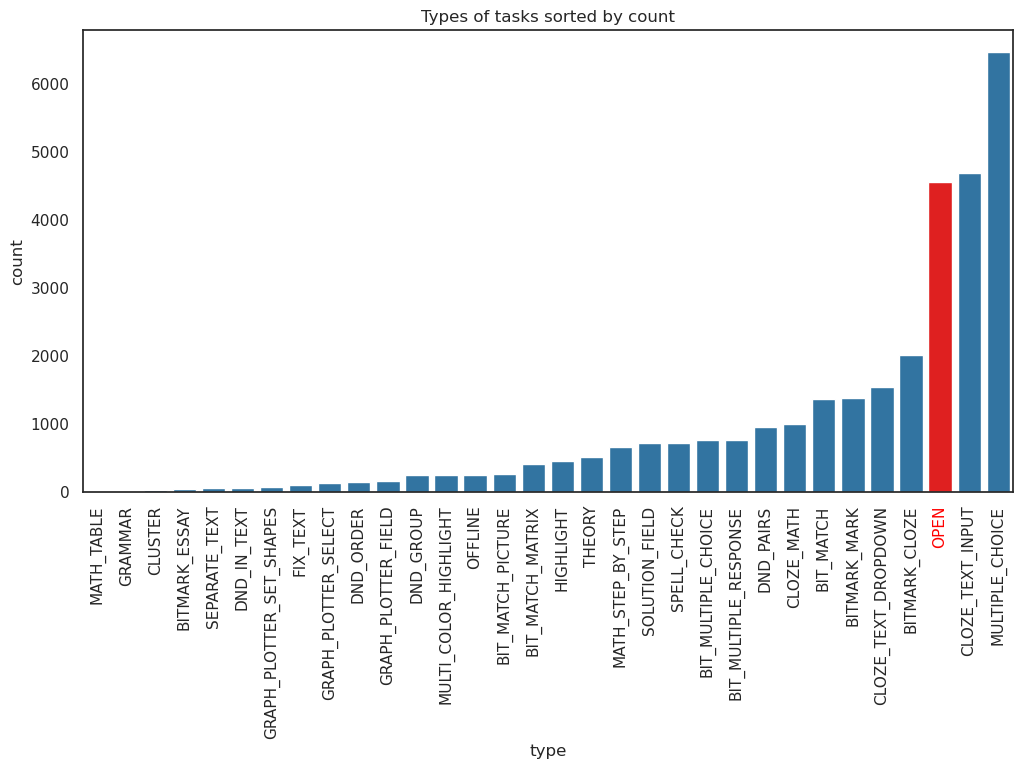

In [8]:
types_count = df_latest_task_versions[["type", "taskId"]].groupby("type").count().rename(columns={"taskId":"count"}).reset_index()

colors = ['tab:blue' for x in types_count.type]
colors[-3] = 'red'

ax = sns.barplot(data=types_count,
                 x='type',
                 y="count",
                 order=types_count.sort_values('count').type, palette=colors)

plt.xticks(rotation=90)
ax.get_xticklabels()[-3].set_color("red")
title = plt.title("Types of tasks sorted by count")
ax.get_figure().savefig("figures/types_count_sorted.png", bbox_inches="tight") 


In [9]:
open_count = types_count[types_count['type'] == "OPEN"].reset_index().loc[0,"count"]
print("Percentage of OPEN tasks: {:.2f}%".format(open_count / types_count['count'].sum() * 100))

Percentage of OPEN tasks: 14.78%


<hr>

# Tenants

In [10]:
df_latest_task_versions.head()

,version,taskId,title,typeId,createdTime_x,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,isCommaMode,isReferenceTask,isMultipleChoice,type,id,createdTime_y
0,2325,PT1-11a-restored,Aufgabe PT1.11a,3,1535643328825,2,"{""id"": ""PT1-11a-restored"", ""type"": ""HIGHLIGHT""...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,2693,1534434704301
1,2388,7kQh-veLQfOanjx1QkhbKx,Aufgabe PT 2.14a,3,1535660365797,2,"{""id"": ""7kQh-veLQfOanjx1QkhbKx"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,1589,1532335779747
2,2395,d7SwsoVyAUP80fMioyhxzH,Aufgabe PT 2.14c,3,1535661392063,2,"{""id"": ""d7SwsoVyAUP80fMioyhxzH"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,2516,1532336772750
3,3786,4R58yTMxw8b5CK1F72eh0W,Musteraufgabe D_Markieren_Adjektive_3.4_WORT_A_1,3,1562516756370,32,"{""id"": ""4R58yTMxw8b5CK1F72eh0W"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,927,1559076209311
4,3788,2UiRhzBKL217r4pFiCA6Ek,Ersatz 1.6b_Markieren mit mehreren Farben,3,1562516867617,32,"{""id"": ""2UiRhzBKL217r4pFiCA6Ek"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,HIGHLIGHT,425,1555145282057


In [11]:
# Get titles and descriptions of last versions of tasks 
df = df_latest_task_versions[["title", "content"]]
df = pd.concat([df, df["content"].apply(json.loads).apply(pd.Series)], axis=1)
columns_to_keep = ["id", "type", "description", "solution", "sampleSolutions", "language", "tenant", "topic", "context"]
df_content = df[columns_to_keep]
df_content.head()

,id,type,description,solution,sampleSolutions,language,tenant,topic,context
0,PT1-11a-restored,HIGHLIGHT,"<p><strong>Woran erkennst du, dass die Hexe im...",NaN,NaN,NaN,NaN,NaN,NaN
1,7kQh-veLQfOanjx1QkhbKx,HIGHLIGHT,<p><strong>Der nachfolgende Text ist jeweils d...,NaN,NaN,NaN,NaN,NaN,NaN
2,d7SwsoVyAUP80fMioyhxzH,HIGHLIGHT,<p><strong>Markiere die drei Konkretisierungen...,NaN,NaN,NaN,NaN,NaN,NaN
3,4R58yTMxw8b5CK1F72eh0W,HIGHLIGHT,<p><strong>Markiere im folgenden Text alle Adj...,NaN,NaN,NaN,NaN,NaN,NaN
4,2UiRhzBKL217r4pFiCA6Ek,HIGHLIGHT,"<p>Bestimme, welche Fehlerart bei den markiert...",NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tenants = df_content["tenant"].apply(pd.Series)[["name"]]
tenants.rename(columns={"name":"tenant_name"}, inplace=True)
df_content = pd.concat([df_content, tenants], axis=1)

,tenant_name
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [14]:
df_content.head()

,id,type,description,solution,sampleSolutions,language,tenant,topic,context,tenant_name
0,PT1-11a-restored,HIGHLIGHT,"<p><strong>Woran erkennst du, dass die Hexe im...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7kQh-veLQfOanjx1QkhbKx,HIGHLIGHT,<p><strong>Der nachfolgende Text ist jeweils d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d7SwsoVyAUP80fMioyhxzH,HIGHLIGHT,<p><strong>Markiere die drei Konkretisierungen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4R58yTMxw8b5CK1F72eh0W,HIGHLIGHT,<p><strong>Markiere im folgenden Text alle Adj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2UiRhzBKL217r4pFiCA6Ek,HIGHLIGHT,"<p>Bestimme, welche Fehlerart bei den markiert...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_content["type"] = df_content["type"].apply(lambda t: t if t=="OPEN" else "OTHER")

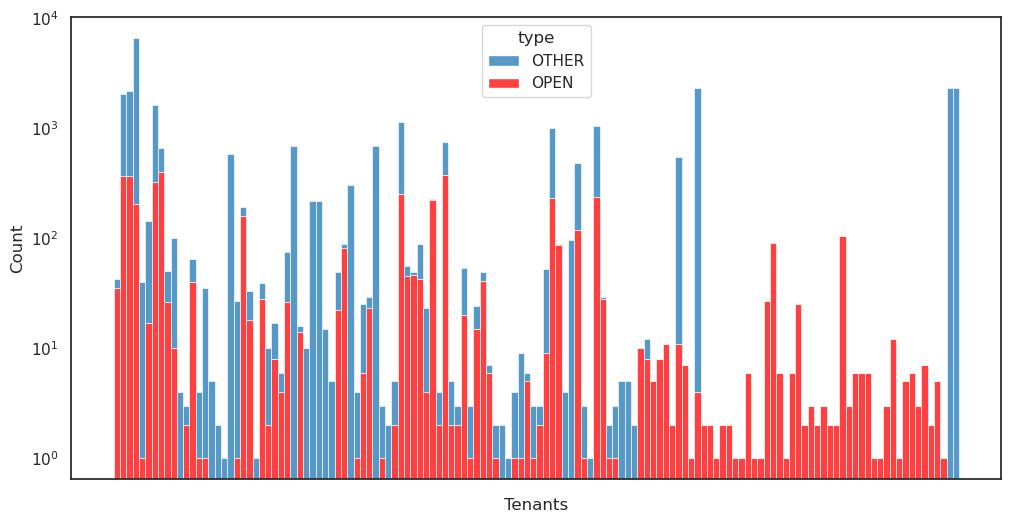

In [17]:
# Distribution of tasks' types among tenants 
ax = sns.histplot(data=df_content,
                  x="tenant_name",
                  hue="type",
                  multiple="stack", 
                  palette=["tab:blue", "red"],
                 )
ax.set_yscale("log")
ax.set_xticklabels('')
ax.set_xlabel("Tenants")
ax.get_figure().savefig("figures/types_tenants.png", bbox_inches="tight") 
plt.show()

# OPEN tasks

In [20]:
df_open = df_content[df_content["type"] == "OPEN"]

In [21]:
df_open["language"].unique()

array([nan, 'EN', 'FR', 'DE', 'IT', 'DE_DE'], dtype=object)

In [22]:
# How many tasks with language specified ? 
L = len(df_open)
print("{:.2f}%".format(len(df_open["language"].dropna()) / L * 100))

74.25%


In [24]:
l = len(df_open[df_open["language"].isna()])
nan_perc = l/L
print("Nan:  {:.2f}%".format(nan_perc*100))

Nan:  25.75%


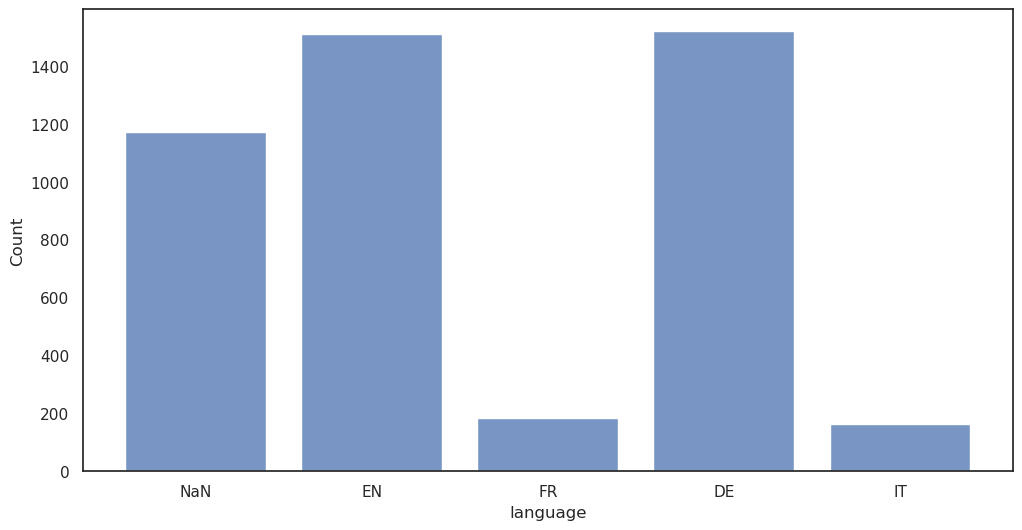

In [25]:
df_open["language"] = df_open["language"].apply(lambda l: "NaN" if str(l) == "nan" else l)
df_open["language"] = df_open["language"].apply(lambda l: "DE" if l == "DE_DE" else l)

ax = sns.histplot(data=df_open,
                  x="language",
                  shrink=0.8)
# title = plt.title("Distribution of languages of the OPEN tasks.")
ax.get_figure().savefig("figures/languages_distribution.png", bbox_inches="tight") 

In [26]:
# Portion of DE/EN tasks
print("{:.2f}%".format(len(df_open[df_open["language"].isin(["DE", "EN"])]) / L * 100))

66.62%


In [27]:
# How many tasks with solution ?
print("{:.2f}%".format(len(df_open["solution"].dropna()) / L * 100))

0.00%


In [28]:
# How many tasks with topic specified ? 
print("{:.2f}%".format(len(df_open["topic"].dropna()) / L * 100))

27.29%


In [29]:
# How many tasks with tenant specified ? 
print("{:.2f}%".format(len(df_open["tenant"].dropna()) / L * 100))

96.68%


# Content

In [30]:
df_open.head()

,id,type,description,solution,sampleSolutions,language,tenant,topic,context,tenant_name
16004,4HNL62l.47Ta0sHqrOzKoF,OPEN,<p>Was hat dir besonders gut gefallen? </p>,NaN,[],NaN,NaN,NaN,NaN,NaN
16005,aCF0hfb1kQEayDOqwEp0s1,OPEN,<p>Was k&ouml;nnte verbessert werden?</p>,NaN,[],NaN,NaN,NaN,NaN,NaN
16006,dCZ4cWixQrM9ovYwc-TP.z,OPEN,<p>Welche wichtigen Features fehlen in unserer...,NaN,[],NaN,NaN,NaN,NaN,NaN
16007,8iXTTKYbQ.Hbd8daUV8dcQ,OPEN,<p>Was hat Ihnen besonders gut gefallen?</p>,NaN,[],NaN,NaN,NaN,NaN,NaN
16008,eEFZ3WW6kHx9rb9tdtx0AZ,OPEN,<p>Was k&ouml;nnte verbessert werden?</p>,NaN,[],NaN,NaN,NaN,NaN,NaN


In [31]:
# Lengths of descriptions => need pre-processing ? cleaning html tags 
clean_descriptions = df_open[["id", "description", "language", "context", "tenant_name"]]
clean_descriptions.rename(columns={"id":"taskId"}, inplace=True) 
clean_descriptions["description"] = clean_descriptions["description"].apply(lambda str: BeautifulSoup(str, 'html.parser').get_text().strip())
clean_descriptions = pd.DataFrame(clean_descriptions.reset_index(drop=True))
clean_descriptions["word_count"] = clean_descriptions["description"].apply(lambda s: len(s.split()))
clean_descriptions.sort_values(by="word_count", inplace=True)
L = len(clean_descriptions)

In [32]:
clean_descriptions.head()

,taskId,description,language,context,tenant_name,word_count
653,2h4Cy3wj0Dz7xYBXEhBMcf,,NaN,NaN,connectsolutions_en,0
898,3P6AbX1HlCU6uPMIaApL8H,,EN,NaN,Playground,0
2286,rtjB7FDzEm5DhSkOkqLF5,,EN,NaN,demo,0
2287,7zfPuYc7lDJ6zTSDsSpgEM,,EN,NaN,demo,0
2292,9NO7tQxi7qD8EWU5MkqeRk,,EN,NaN,Playground,0


In [33]:
clean_descriptions[~clean_descriptions["language"].isin(["FR", "IT"])].to_csv("data/EDA_result.csv", index_label=False)

In [34]:
df_both = clean_descriptions[clean_descriptions["language"].isin(["DE", "EN"])]

In [39]:
df_both = df_both.sort_values(by="language")

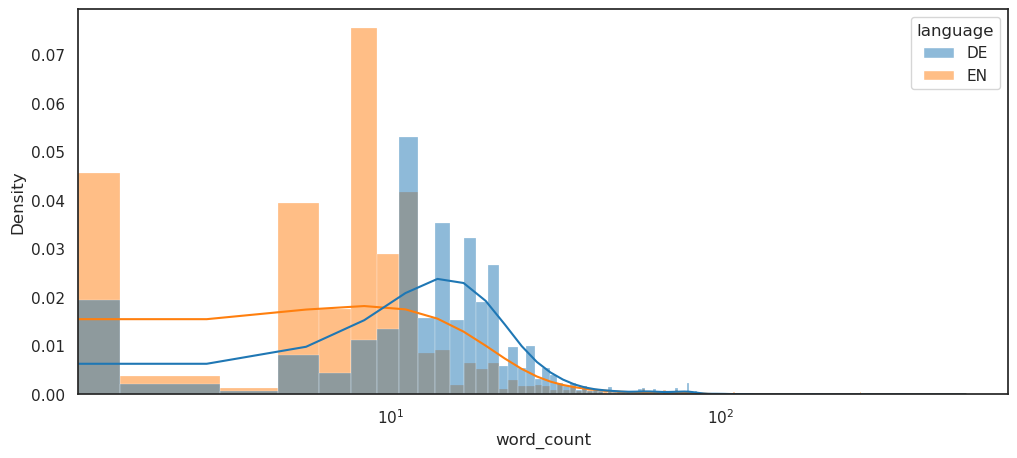

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.histplot(data=df_both, x="word_count", hue="language", kde=True, stat="density", palette=["tab:blue", "tab:orange"])
ax.set_xscale("log")

fig.savefig("figures/description_lengths_1", bbox_inches="tight") 

In [36]:
# How many empty descriptions ?
empty = df_both[df_both["word_count"] == 0]
print("Empty descriptions: {:.2f}%".format(len(empty) / L * 100))

# How many short descriptions ?
tail = df_both[df_both["word_count"] < 5]
print("Descriptions of < 5 words: {:.2f}%".format(len(tail) / L * 100))

# How many short descriptions ?
tail = df_both[df_both["word_count"] < 10]
print("Descriptions of < 10 words: {:.2f}%".format(len(tail) / L * 100))

# How heavy is the tail ?
tail = df_both[df_both["word_count"] > 100]
print("Descriptions of > 100 words: {:.2f}%".format(len(tail) / L * 100))

# How heavy is the tail ?
tail = df_both[df_both["word_count"] > 200]
print("Descrishaggy & daddyptions of > 200 words: {:.2f}%".format(len(tail) / L * 100))

Empty descriptions: 5.60%
Descriptions of < 5 words: 7.38%
Descriptions of < 10 words: 23.20%
Descriptions of > 100 words: 0.66%
Descrishaggy & daddyptions of > 200 words: 0.35%


> The distribution of the length of task description (in number of words) is heavy-tailed. Descriptions of more than 100 words count for less than 1% of the dataset and so can be discarded. Empty descriptions however count for almost 10% of the dataset.
> More than half of the dataset of English and German tasks have short descriptions, of less than 10 words.

<hr>

# Aspects

In [60]:
# All Aspects
query = "SELECT * FROM Aspects"
df_aspects = pd.read_sql(query, cnx)
df_aspects.rename(columns={"id":"aspectId"}, inplace=True)
df_aspects = df_aspects[["aspectId", "description", "type", "groupId", "categoryId"]]
# df_aspects.to_csv("data/aspects.csv", index_label=False)
df_aspects.head()

,aspectId,description,type,groupId,categoryId
0,1,To enable them on this domain,CONCEPT,1067.0,NaN
1,2,To enable competences for smoke tests,CONCEPT,48.0,NaN
2,4,Die Antwort wurde in einem Satz gegeben.,CONCEPT,674.0,NaN
3,17,"Es wurde erkannt, dass die Schafe vorzeitig in...",CONCEPT,95.0,NaN
4,18,"Es wurde erkannt, dass in Schweden der Erhalt ...",CONCEPT,73.0,NaN


In [61]:
L = len(df_aspects)

In [62]:
df_aspects.type.unique(), len(df_aspects[df_aspects["type"] == "CONCEPT"]), len(df_aspects[df_aspects["type"] == "MISCONCEPTION"])

(array(['CONCEPT', 'MISCONCEPTION'], dtype=object), 3879, 7980)

In [63]:
len(df_aspects.groupId.unique())

3009

In [64]:
len(df_aspects.categoryId.unique())

39

In [65]:
df_aspects = df_aspects[df_aspects["type"] == "CONCEPT"]
L = len(df_aspects)

In [66]:
L 

3879

In [67]:
# Portion of aspects with specified groupId
len(df_aspects.dropna(subset=["groupId"])) / L * 100

86.18200567156484

In [68]:
# Portion of aspects with specified categoryId
len(df_aspects.dropna(subset=["categoryId"])) / L * 100

60.32482598607889